In [37]:
using JuMP,Gurobi
using Ipopt
using GLPKMathProgInterface
# using Cbc
using DataArrays, DataFrames, CSV
using Gadfly
using Pajarito 
using Pavito
using ECOS
using AmplNLWriter, CoinOptServices
using NLopt
using Mosek
using KNITRO

In [38]:
###  Data definition
#Generators data

GenData = DataFrame(
    Bus = [18,21,1,2,15,16,23,23,7,13,15,22],
    Pmax = [400,400,152,152,155,155,310,350,350,591,60,300],
    Pmin = [100,100,30.40,30.40,54.25,54.25,108.50,140,75,206.85,12,0],
    Qmax = [400,400,192,192,155,155,250,310,300,591,30,300],
    Qmin = [-50,-50,-50,-50,-50,-50,-50,-125,0,0,0,-60],
    c = [5.47,5.47,13.32,13.32,16,10.52,10.52,10.89,20.7,20.93,26.11,0],
    a = [0.005,0.006,0.007,0.004,0.005,0.007,0.005,0.003,0.004,0.005,0.007,0.008],
    RU = [47,47,14,14,21,21,21,28,49,21,7,35],
    RD = [47,47,14,14,21,21,21,28,49,21,7,35])

#Number of generators
NGen = size(GenData,1) 
# Generator limits
Pmin = zeros(NGen); 
Pmax = zeros(NGen); 
Qmin = zeros(NGen); 
Qmax = zeros(NGen);
# Generation costs
c = zeros(NGen);
a = zeros(NGen);
Bus = zeros(NGen);
#RumpUp
RU = zeros(NGen);
#RumpDown
RD = zeros(NGen);



for i=1:NGen
    Bus[i] = GenData[i,:Bus]
    Pmin[i] = GenData[i,:Pmin]
    Pmax[i] = GenData[i,:Pmax]
    Qmin[i] = GenData[i,:Qmin]
    Qmax[i] = GenData[i,:Qmax]
    c[i] = GenData[i,:c]
    a[i] = GenData[i,:a]
    RU[i] = GenData[i,:RU]
    RD[i] = GenData[i,:RD]
    
    
end    
    
GenData

12×9 DataFrames.DataFrame
│ Row │ Bus │ Pmax │ Pmin   │ Qmax │ Qmin │ c     │ a     │ RU │ RD │
├─────┼─────┼──────┼────────┼──────┼──────┼───────┼───────┼────┼────┤
│ 1   │ 18  │ 400  │ 100.0  │ 400  │ -50  │ 5.47  │ 0.005 │ 47 │ 47 │
│ 2   │ 21  │ 400  │ 100.0  │ 400  │ -50  │ 5.47  │ 0.006 │ 47 │ 47 │
│ 3   │ 1   │ 152  │ 30.4   │ 192  │ -50  │ 13.32 │ 0.007 │ 14 │ 14 │
│ 4   │ 2   │ 152  │ 30.4   │ 192  │ -50  │ 13.32 │ 0.004 │ 14 │ 14 │
│ 5   │ 15  │ 155  │ 54.25  │ 155  │ -50  │ 16.0  │ 0.005 │ 21 │ 21 │
│ 6   │ 16  │ 155  │ 54.25  │ 155  │ -50  │ 10.52 │ 0.007 │ 21 │ 21 │
│ 7   │ 23  │ 310  │ 108.5  │ 250  │ -50  │ 10.52 │ 0.005 │ 21 │ 21 │
│ 8   │ 23  │ 350  │ 140.0  │ 310  │ -125 │ 10.89 │ 0.003 │ 28 │ 28 │
│ 9   │ 7   │ 350  │ 75.0   │ 300  │ 0    │ 20.7  │ 0.004 │ 49 │ 49 │
│ 10  │ 13  │ 591  │ 206.85 │ 591  │ 0    │ 20.93 │ 0.005 │ 21 │ 21 │
│ 11  │ 15  │ 60   │ 12.0   │ 30   │ 0    │ 26.11 │ 0.007 │ 7  │ 7  │
│ 12  │ 22  │ 300  │ 0.0    │ 300  │ -60  │ 0.0   │ 0.008 │ 35 │ 35 │

In [39]:
# Lines data
BranchData = DataFrame(
    FromBus = [1,1,1,2,2,3,3,4,5,6,7,8,8,9,9,10,10,11,11,12,12,13,14,15,15,15,16,16,17,17,18,19,20,21],
    ToBus = [2,3,5,4,6,9,24,9,10,10,8,9,10,11,12,11,12,13,14,13,23,23,16,16,21,24,17,19,18,22,21,20,23,22],
    r = [0.0026,0.0546,0.0218,0.0328,0.0497,0.0308,0.0023,0.0268,0.0228,0.0139,0.0159,0.0427,0.0427,0.0023,0.0023,0.0023,0.0023,0.0061,0.0054,0.0061,0.0124,0.0111,0.0050,0.0022,0.0032,0.0067,0.0033,0.0030,0.0018,0.0135,0.0017,0.0026,0.0014,0.0087],
    x = [0.0139,0.2112,0.0845,0.1267,0.1920,0.1190,0.0839,0.1037,0.0883,0.0605,0.0614,0.1651,0.1651,0.0839,0.0839,0.0839,0.0839,0.0476,0.0418,0.0476,0.0966,0.0865,0.0389,0.0173,0.0245,0.0519,0.0259,0.0231,0.0144,0.1053,0.0130,0.0198,0.0108,0.0678],
    b = [0.4611,0.0572,0.0229,0.0343,0.0520,0.0322,0.0000,0.0281,0.0239,2.4590,0.0166,0.0447,0.0447,0.0000,0.0000,0.0000,0.0000,0.0999,0.0879,0.0999,0.2030,0.1818,0.0818,0.0364,0.2060,0.1091,0.0545,0.0485,0.0303,0.2212,0.1090,0.1666,0.0910,0.1424],
    Smax = [175,175,175,175,175,175,400,175,175,175,175,175,175,400,400,400,400,500,500,500,500,500,500,500,1000,500,500,500,500,500,1000,1000,1000,500],)


NBuses = max(maximum(BranchData[:,:FromBus]), maximum(BranchData[:,:ToBus]));
NLines = size(BranchData,1);
BranchData[:Z]=BranchData[:r]+im*BranchData[:x];
BranchData[:Y]=1./BranchData[:Z];
Ybus = zeros(Complex,NBuses,NBuses);
Nodes = zeros(Int8,NLines,2); #node's matrix
SLmax = zeros(NLines); #line limits
x = zeros(NLines);
r = zeros(NLines);
z = zeros(NLines)


for i=1:NLines
    
    Ybus[BranchData[i,:FromBus],BranchData[i,:ToBus]]=-BranchData[i,:Y]
    Ybus[BranchData[i,:ToBus],BranchData[i,:FromBus]]=-BranchData[i,:Y]
    Nodes[i,1] = BranchData[i,:FromBus]
    Nodes[i,2] = BranchData[i,:ToBus]
    SLmax[i] = BranchData[i,:Smax]
    x[i] = BranchData[i,:x]
    r[i] = BranchData[i,:r]
    z[i] = sqrt(BranchData[i,:r]^2+BranchData[i,:x]^2)
   
end

for i=1:NBuses
    for j=1:NLines
        if (i==BranchData[j,:FromBus])||(i==BranchData[j,:ToBus])
            Ybus[i,i]+=BranchData[j,:Y]
        end
    end
end

Gbus = real(Ybus);
Bbus = imag(Ybus);

BranchData


34×8 DataFrames.DataFrame. Omitted printing of 1 columns
│ Row │ FromBus │ ToBus │ r      │ x      │ b      │ Smax │ Z               │
├─────┼─────────┼───────┼────────┼────────┼────────┼──────┼─────────────────┤
│ 1   │ 1       │ 2     │ 0.0026 │ 0.0139 │ 0.4611 │ 175  │ 0.0026+0.0139im │
│ 2   │ 1       │ 3     │ 0.0546 │ 0.2112 │ 0.0572 │ 175  │ 0.0546+0.2112im │
│ 3   │ 1       │ 5     │ 0.0218 │ 0.0845 │ 0.0229 │ 175  │ 0.0218+0.0845im │
│ 4   │ 2       │ 4     │ 0.0328 │ 0.1267 │ 0.0343 │ 175  │ 0.0328+0.1267im │
│ 5   │ 2       │ 6     │ 0.0497 │ 0.192  │ 0.052  │ 175  │ 0.0497+0.192im  │
│ 6   │ 3       │ 9     │ 0.0308 │ 0.119  │ 0.0322 │ 175  │ 0.0308+0.119im  │
│ 7   │ 3       │ 24    │ 0.0023 │ 0.0839 │ 0.0    │ 400  │ 0.0023+0.0839im │
│ 8   │ 4       │ 9     │ 0.0268 │ 0.1037 │ 0.0281 │ 175  │ 0.0268+0.1037im │
│ 9   │ 5       │ 10    │ 0.0228 │ 0.0883 │ 0.0239 │ 175  │ 0.0228+0.0883im │
│ 10  │ 6       │ 10    │ 0.0139 │ 0.0605 │ 2.459  │ 175  │ 0.0139+0.0605im │
│ 11  │ 7       │ 8     │ 0.0159 │ 0.0614 │ 0.0166 │ 175  │ 0.0159+0.0614im │
⋮
│ 23  │ 14      │ 16    │ 0.005  │ 0.0389 │ 0.0818 │ 500  │ 0.005+0.0389im  │
│ 24  │ 15      │ 16    │ 0.0022 │ 0.0173 │ 0.0364 │ 500  │ 0.0022+0.0173im │
│ 25  │ 15      │ 21    │ 0.0032 │ 0.0245 │ 0.206  │ 1000 │ 0.0032+0.0245im │
│ 26  │ 15      │ 24    │ 0.0067 │ 0.0519 │ 0.1091 │ 500  │ 0.0067+0.0519im │
│ 27  │ 16      │ 17    │ 0.0033 │ 0.0259 │ 0.0545 │ 500  │ 0.0033+0.0259im │
│ 28  │ 16      │ 19    │ 0.003  │ 0.0231 │ 0.0485 │ 500  │ 0.003+0.0231im  │
│ 29  │ 17      │ 18    │ 0.0018 │ 0.0144 │ 0.0303 │ 500  │ 0.0018+0.0144im │
│ 30  │ 17      │ 22    │ 0.0135 │ 0.1053 │ 0.2212 │ 500  │ 0.0135+0.1053im │
│ 31  │ 18      │ 21    │ 0.0017 │ 0.013  │ 0.109  │ 1000 │ 0.0017+0.013im  │
│ 32  │ 19      │ 20    │ 0.0026 │ 0.0198 │ 0.1666 │ 1000 │ 0.0026+0.0198im │
│ 33  │ 20      │ 23    │ 0.0014 │ 0.0108 │ 0.091  │ 1000 │ 0.0014+0.0108im │
│ 34  │ 21      │ 22    │ 0.0087 │ 0.0678 │ 0.1424 │ 500  │ 0.0087+0.0678im │

In [40]:
NodesData = DataFrame(
    Pd = [108,97,180,74,71,136,125,171,175,195,0,0,265,194,317,100,0,333,181,128,0,0,0,0],
    Qd = [22,20,37,15,14,28,25,35,36,40,0,0,54,39,64,20,0,68,37,26,0,0,0,0],
    Wind = [0,0,0,0,0,0,0,200,0,0,0,0,0,0,0,0,0,0,150,0,100,0,0,0],
    SOC = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,100,0,0,0],
)
ScaleData = DataFrame(
    w = [0.0786666666666667,0.0866666666666667,0.117333333333333,0.258666666666667,0.361333333333333,0.566666666666667,0.650666666666667,0.566666666666667,0.484,0.548,0.757333333333333,0.710666666666667,0.870666666666667,0.932,0.966666666666667,1,0.869333333333333,0.665333333333333,0.656 ,0.561333333333333,0.565333333333333,0.556,0.724,0.84],
    d = [0.684511335492475,0.644122690036197,0.61306915602972,0.599733282530006,0.588874071251667,0.5980186702229,0.626786054486569,0.651743189178891,0.706039245570585,0.787007048961707,0.839016955610593,0.852733854067441,0.870642027052772,0.834254143646409,0.816536483139646,0.819394170318156,0.874071251666984,1,0.983615926843208,0.936368832158506,0.887597637645266,0.809297008954087,0.74585635359116,0.733473042484283],
)
    
T = size(ScaleData,1); #Time scale

Pload = zeros(NBuses); # Demand
Qload = zeros(NBuses); 
Wind = zeros(NBuses); #Wind turbaine capacity
SOC_d = zeros(NBuses); #SOC capacity

w = zeros(T); #Wind profile coefficients
d = zeros(T);  #Demand profile coefficients


for i=1:NBuses
    
    Pload[i] = NodesData[i,:Pd]
    Qload[i] = NodesData[i,:Qd]
    Wind[i] = NodesData[i,:Wind]
    SOC_d[i] = NodesData[i,:SOC]
   
end

for i=1:T
    w[i] = ScaleData[i,:w]
    d[i] = ScaleData[i,:d]
end

# Voltage limits
Vmin = 0.9;
Vmax = 1.15;

#Angle limits

θmax = pi/2;
θmin = -pi/2;

SlackBus = 13;

Sbase = 100;

SOC_max = 20;
#SOC_max = SOC_d
SOC_min = 0.2*SOC_max;
SOC_0 = 0.2*SOC_max; #initial charge
Pd_min = 0*SOC_max; #discharge limits
Pd_max = 0.2*SOC_max;
Pc_min = 0*SOC_max; #charge limits
Pc_max = 0.2*SOC_max;
r_loss = 0.5; #ESS loses
#charge/discharge efficiency 
ηс = 0.95;
ηd = 0.9;

#Wind power limits
Pw_min = 0*Wind;
Pw_max = Wind;
Pwc_min = 0*Wind;
Pwc_max = Wind;
#Load shedding limits
Ls_min = 0*Pload;
Ls_max = Pload;

VOLL = 10000;
VOLW = 50;

N_max = 15; #total number of ESS in the system
NESS_max = 5; #limit of ESS in the bus

NodesData


24×4 DataFrames.DataFrame
│ Row │ Pd  │ Qd │ Wind │ SOC │
├─────┼─────┼────┼──────┼─────┤
│ 1   │ 108 │ 22 │ 0    │ 0   │
│ 2   │ 97  │ 20 │ 0    │ 0   │
│ 3   │ 180 │ 37 │ 0    │ 0   │
│ 4   │ 74  │ 15 │ 0    │ 0   │
│ 5   │ 71  │ 14 │ 0    │ 0   │
│ 6   │ 136 │ 28 │ 0    │ 0   │
│ 7   │ 125 │ 25 │ 0    │ 0   │
│ 8   │ 171 │ 35 │ 200  │ 0   │
│ 9   │ 175 │ 36 │ 0    │ 0   │
│ 10  │ 195 │ 40 │ 0    │ 0   │
│ 11  │ 0   │ 0  │ 0    │ 0   │
│ 12  │ 0   │ 0  │ 0    │ 0   │
│ 13  │ 265 │ 54 │ 0    │ 0   │
│ 14  │ 194 │ 39 │ 0    │ 0   │
│ 15  │ 317 │ 64 │ 0    │ 0   │
│ 16  │ 100 │ 20 │ 0    │ 0   │
│ 17  │ 0   │ 0  │ 0    │ 0   │
│ 18  │ 333 │ 68 │ 0    │ 0   │
│ 19  │ 181 │ 37 │ 150  │ 200 │
│ 20  │ 128 │ 26 │ 0    │ 0   │
│ 21  │ 0   │ 0  │ 100  │ 100 │
│ 22  │ 0   │ 0  │ 0    │ 0   │
│ 23  │ 0   │ 0  │ 0    │ 0   │
│ 24  │ 0   │ 0  │ 0    │ 0   │

In [41]:
# Set size
NI = NBuses;
NL = NLines;
NG = NGen;


In [42]:
#m = Model(solver = GLPKSolverMIP())
#m = Model(solver = IpoptSolver());
#m = Model(solver =  CbcSolver());
#m = Model(solver = PajaritoSolver(mip_solver = GLPKSolverMIP())
#m = Model(solver = ECOS.ECOSSolver())
#m = Model(solver = NLoptSolver(algorithm=:LD_SLSQP))#:LD_MMA
#solver=CplexSolver
#m = Model(solver = PajaritoSolver(mip_solver = GLPKSolverMIP(), cont_solver = IpoptSolver()))   
#m=Model(solver = PajaritoSolver(mip_solver = GLPKSolverMIP(), cont_solver =  AmplNLSolver("bonmin")))
#m = Model(solver=AmplNLSolver(CoinOptServices.bonmin))
#m = Model(solver=AmplNLSolver(CoinOptServices.couenne))
#m = Model(solver = PavitoSolver(mip_solver = GLPKSolverMIP(), cont_solver = IpoptSolver()))   
#m = Model(solver = PavitoSolver(mip_solver = GLPKSolverMIP(), cont_solver = NLoptSolver(algorithm=:LD_MMA)))   
#m = Model(solver=GurobiSolver(Presolve=0))
#m = Model(solver=MosekSolver())
m = Model(solver=KnitroSolver(KTR_PARAM_ALG=KTR_ALG_MULTI))

Feasibility problem with:
 * 0 linear constraints
 * 0 variables
Solver is Knitro

In [43]:
#T=6

In [44]:
@variable(m, p[g=1:NG,t=1:T]);
@variable(m, q[g=1:NG,t=1:T]);

@variable(m, pl[l=1:2*NL,t=1:T]);
@variable(m, ql[l=1:2*NL,t=1:T]);

@variable(m, v[i=1:NI,t=1:T]);
@variable(m, θ[i=1:NI,t=1:T]);

@variable(m, Ls[i=1:NI,t=1:T]);
@variable(m, SOC[i=1:NI,t=1:T]);
@variable(m, pd[i=1:NI,t=1:T]);
@variable(m, pc[i=1:NI,t=1:T]);
@variable(m, pw[i=1:NI,t=1:T]);
@variable(m, pwc[i=1:NI,t=1:T]);
@variable(m, NESS[i=1:NI], Int);
#@variable(m, NESS[i=1:NI]);
#@variable(m, ESS_loss[i=1:NI,t=1:T]);

In [45]:
#Nodal balance equation
@constraint(m, BalanceEqP[i=1:NI, t=1:T], sum(p[g,t] for g=1:NG if Bus[g]==i) + Ls[i,t] + pw[i,t] - Pload[i]*d[t]/Sbase - pc[i,t] + pd[i,t]  == 
                sum(pl[l,t] for l=1:NL if Nodes[l,1]==i) + sum(pl[l,t] for l=NL+1:2*NL if Nodes[l-NL,2]==i));
                                        
@constraint(m, BalanceEqQ[i=1:NI, t=1:T], sum(q[g,t] for g=1:NG if Bus[g]==i) - Qload[i]*d[t]/Sbase  == 
                sum(ql[l,t] for l=1:NL if Nodes[l,1]==i) + sum(ql[l,t] for l=NL+1:2*NL if Nodes[l-NL,2]==i));
                                                                                


In [46]:
#Branch power flow defenition
@NLconstraint(m, PowerFlowP1[l=1:NL,t=1:T], pl[l,t] >= -v[Nodes[l,1],t]^2*Gbus[Nodes[l,1],Nodes[l,2]] + v[Nodes[l,1],t]*v[Nodes[l,2],t]*(Gbus[Nodes[l,1],Nodes[l,2]]*cos(θ[Nodes[l,1],t]-θ[Nodes[l,2],t]) + Bbus[Nodes[l,1],Nodes[l,2]]*sin(θ[Nodes[l,1],t]-θ[Nodes[l,2],t])))

@NLconstraint(m, PowerFlowP2[l=NL+1:2*NL,t=1:T], pl[l,t] >= -v[Nodes[l-NL,2],t]^2*Gbus[Nodes[l-NL,2],Nodes[l-NL,1]] + v[Nodes[l-NL,2],t]*v[Nodes[l-NL,1],t]*(Gbus[Nodes[l-NL,2],Nodes[l-NL,1]]*cos(θ[Nodes[l-NL,2],t]-θ[Nodes[l-NL,1],t]) + Bbus[Nodes[l-NL,2],Nodes[l-NL,1]]*sin(θ[Nodes[l-NL,2],t]-θ[Nodes[l-NL,1],t])))

@NLconstraint(m, PowerFlowQ1[l=1:NL,t=1:T], ql[l,t] >= v[Nodes[l,1],t]^2*Bbus[Nodes[l,1],Nodes[l,2]] + v[Nodes[l,1],t]*v[Nodes[l,2],t]*(-Bbus[Nodes[l,1],Nodes[l,2]]*cos(θ[Nodes[l,1],t]-θ[Nodes[l,2],t]) + Gbus[Nodes[l,1],Nodes[l,2]]*sin(θ[Nodes[l,1],t]-θ[Nodes[l,2],t])))

@NLconstraint(m, PowerFlowQ2[l=NL+1:2*NL,t=1:T], ql[l,t] >= v[Nodes[l-NL,2],t]^2*Bbus[Nodes[l-NL,2],Nodes[l-NL,1]] + v[Nodes[l-NL,2],t]*v[Nodes[l-NL,1],t]*(-Bbus[Nodes[l-NL,2],Nodes[l-NL,1]]*cos(θ[Nodes[l-NL,2],t]-θ[Nodes[l-NL,1],t]) + Gbus[Nodes[l-NL,2],Nodes[l-NL,1]]*sin(θ[Nodes[l-NL,2],t]-θ[Nodes[l-NL,1],t])))


@NLconstraint(m, FlowLimits1[l=1:NL,t=1:T], pl[l,t]^2+ql[l,t]^2 <= (SLmax[l]/Sbase)^2);
@NLconstraint(m, FlowLimits2[l=NL+1:2*NL,t=1:T], pl[l,t]^2+ql[l,t]^2 <= (SLmax[l-NL]/Sbase)^2);

In [47]:
#Technical generation limits
@constraint(m, GenLimitsP[g=1:NG,t=1:T], Pmin[g]/Sbase <= p[g,t] <= Pmax[g]/Sbase);
@constraint(m, GenLimitsQ[g=1:NG,t=1:T], Qmin[g]/Sbase <= q[g,t] <= Qmax[g]/Sbase);
@constraint(m, RumpUp[g=1:NG,t=2:T], p[g,t] - p[g,t-1]  <= RU[g]/Sbase);
@constraint(m, RumpDown[g=1:NG,t=2:T], p[g,t-1] - p[g,t]  <= RD[g]/Sbase);

In [48]:
#Angle limits
@constraint(m, limitAngle1[i=SlackBus,t=1:T], θ[i,t] == 0);
@constraint(m, limitAngle2[i=1:NI,t=1:T], θmin <= θ[i,t] <= θmax);

#Voltage limits
@constraint(m, VoltageLimits[i=1:NI,t=1:T], Vmin <=v[i,t] <= Vmax);

In [49]:
#Charge balance
@constraint(m,ChargeBal1[i=1:NI,t=1], SOC[i,t] == NESS[i]*SOC_0/Sbase  + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal2[i=1:NI,t=2:T], SOC[i,t] == SOC[i,t-1] + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal3[i=1:NI,t=T], SOC[i,t] == NESS[i]*SOC_0/Sbase);
@constraint(m,ChargeBal4[i=1:NI,t=1:T], SOC[i,t] <= NESS[i]*SOC_max/Sbase);
@constraint(m,ChargeBal5[i=1:NI,t=1:T], pd[i,t] <= NESS[i]*Pd_max/Sbase);
@constraint(m,ChargeBal6[i=1:NI,t=1:T], pc[i,t] <= NESS[i]*Pc_max/Sbase);
@constraint(m,ChargeBal7[i=1:NI,t=1:T], SOC[i,t] >= NESS[i]*SOC_min/Sbase);
@constraint(m,ChargeBal8[i=1:NI,t=1:T], pd[i,t] >= NESS[i]*Pd_min/Sbase);
@constraint(m,ChargeBal9[i=1:NI,t=1:T], pc[i,t] >= NESS[i]*Pc_min/Sbase);
@constraint(m,ChargeBal10, sum(NESS[i] for i=1:NI) <= N_max);
@constraint(m,ChargeBal11[i=1:NI], NESS[i]  <= NESS_max);
# @NLconstraint(m,ChargeBal12[i=1:NI,t=1:T], sqrt((2*sqrt(r_loss)*(pd[i,t]+pc[i,t]))^2 + (1-ESS_loss[i,t])^2) <= 1+ESS_loss[i,t]);
# @constraint(m,ChargeBal13[i=1:NI,t=1:T], 0 <= ESS_loss[i,t]);

# @constraint(m,ChargeBal1[i=1:NI,t=1], SOC[i,t] == SOC_0[i]/Sbase  + pc[i,t]*ηс - pd[i,t]/ηd);
# @constraint(m,ChargeBal2[i=1:NI,t=2:T], SOC[i,t] == SOC[i,t-1] + pc[i,t]*ηс - pd[i,t]/ηd);
# @constraint(m,ChargeBal3[i=1:NI,t=T], SOC[i,t] == SOC_0[i]/Sbase);
# @constraint(m,ChargeBal4[i=1:NI,t=1:T], SOC[i,t] <= SOC_max[i]/Sbase);
# @constraint(m,ChargeBal5[i=1:NI,t=1:T], pd[i,t] <= Pd_max[i]/Sbase);
# @constraint(m,ChargeBal6[i=1:NI,t=1:T], pc[i,t] <= Pc_max[i]/Sbase);
# @constraint(m,ChargeBal7[i=1:NI,t=1:T], SOC[i,t] >= SOC_min[i]/Sbase);
# @constraint(m,ChargeBal8[i=1:NI,t=1:T], pd[i,t] >= Pd_min[i]/Sbase);
# @constraint(m,ChargeBal9[i=1:NI,t=1:T], pc[i,t] >= Pc_min[i]/Sbase);


In [50]:
#Wind constraine
@constraint(m,Wind1[i=1:NI,t=1:T], pw[i,t] + pwc[i,t] == w[t]*Wind[i]/Sbase);
@constraint(m,Wind2[i=1:NI,t=1:T], Pw_min[i]/Sbase <= pw[i,t] <= w[t]*Pw_max[i]/Sbase);
@constraint(m,Wind3[i=1:NI,t=1:T], Pwc_min[i]/Sbase <= pwc[i,t] <= w[t]*Pwc_max[i]/Sbase);

In [51]:
#Load shedding
@constraint(m,Load[i=1:NI,t=1:T], Ls_min[i]/Sbase <= Ls[i,t] <= d[t]*Ls_max[i]/Sbase);

In [62]:
#Objective function
@NLobjective(m, Min, sum(r[l]*(pl[l,t]*2)^2 for l=1:NL,t=1:T) + 
    sum(4*a[g]*p[g,t]^2+c[g]*p[g,t]*2 for g=1:NG,t=1:T)  
    + sum(VOLL*Ls[i,t]*2 for i=1:NI,t=1:T)  
    + sum(VOLW*pwc[i,t]*2 for i=1:NI,t=1:T)
    + sum(r_loss*(pd[i,t]*2+pc[i,t]*2)^2 for i=1:NI,t=1:T)
    )

# @NLobjective(m, Min, #sum(r[l]*(pl[l,t])^2 for l=1:NL,t=1:T) + 
#     sum(c[g]*p[g,t] for g=1:NG,t=1:T)  
#     + sum(VOLL*Ls[i,t] for i=1:NI,t=1:T)  
#     + sum(VOLW*pwc[i,t] for i=1:NI,t=1:T)
# #    + sum(r_loss*(pd[i,t]+pc[i,t])^2 for i=1:NI,t=1:T)
#     )
# @objective(m, Min, sum(c[g]*p[g,t]*Sbase for g=1:NG,t=1:T)
#         + sum(VOLL*Ls[i,t]*Sbase for i=1:NI,t=1:T)  
#         + sum(VOLW*pwc[i,t]*Sbase for i=1:NI,t=1:T)
# );

In [63]:
#print(m)

In [64]:
solve(m)

:Optimal


             Trial License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 11.0.1

algorithm:               5
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_rounding from AUTO to 3.
Knitro changing mip_heuristic from AUTO to 2.
Knitro changing mip_pseudoinit from AUTO to 1.

Problem Characteristics
-----------------------
Objective goal:  Minimize
Objective type:  general
Number of variables:                               8472
    bounded below only:                               0
    bounded above only:                               0
    bounded below and above:                          0
    fixed:                                            0
    free:                                          8472
Number of binary variables:                           0
Number of integer variables:

In [69]:
sum(#a[g]*(getvalue(p[g,t])*Sbase)^2 + 
    c[g]*getvalue(p[g,t])*Sbase for g=1:NG,t=1:T)
sum(getvalue(pwc[i,t])*Sbase for i=1:NI,t=1:T)
#sum(getvalue(Ls[i,t])*Sbase for i=1:NI,t=1:T) 
#sum((r[l]*getvalue(pl[l,t])*Sbase)^2 for l=1:NL,t=1:T)
#sum(r_loss*(getvalue(pd[i,t]*Sbase)+getvalue(pc[i,t])*Sbase)^2 for i=1:NI,t=1:T)

1.037669046310325e-6

In [66]:
getobjectivevalue(m)


8624.100604417945

In [65]:
NESS_f = getvalue(NESS)
#getvalue(Ls)


24-element Array{Float64,1}:
 2.0
 2.0
 0.0
 2.0
 2.0
 3.0
 2.0
 1.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [27]:
Pg=getvalue(p);
GenPower = DataFrame();
GenPower[:g1] = Pg[1,:];
GenPower[:g2] = Pg[2,:];
GenPower[:g3] = Pg[3,:];
GenPower[:g4] = Pg[4,:];
GenPower[:g5] = Pg[5,:];
GenPower[:g6] = Pg[6,:];
GenPower[:g7] = Pg[7,:];
GenPower[:g8] = Pg[8,:];
GenPower[:g9] = Pg[9,:];
GenPower[:g10] = Pg[10,:];
GenPower[:g11] = Pg[11,:];
GenPower[:g12] = Pg[12,:];


GenPower

24×12 DataFrames.DataFrame. Omitted printing of 5 columns
│ Row │ g1      │ g2      │ g3       │ g4       │ g5      │ g6     │ g7    │
├─────┼─────────┼─────────┼──────────┼──────────┼─────────┼────────┼───────┤
│ 1   │ 4.0     │ 4.0     │ 0.444    │ 0.444    │ 0.5425  │ 0.9625 │ 1.505 │
│ 2   │ 4.0     │ 3.77228 │ 0.304    │ 0.304    │ 0.5425  │ 0.7525 │ 1.295 │
│ 3   │ 3.92848 │ 3.30228 │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 4   │ 3.60978 │ 2.83228 │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 5   │ 3.35535 │ 2.36228 │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 6   │ 3.07263 │ 2.12    │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 7   │ 3.06868 │ 2.59    │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 8   │ 3.53868 │ 3.06    │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 1.085 │
│ 9   │ 4.0     │ 3.53    │ 0.304    │ 0.304    │ 0.5425  │ 0.7525 │ 1.295 │
│ 10  │ 4.0     │ 4.0     │ 0.444    │ 0.444    │ 0.5425  │ 0.9625 │ 1.505 │
│ 11  │ 4.0     │ 4.0     │ 0.304001 │ 0.463281 │ 0.5425  │ 1.1725 │ 1.715 │
│ 12  │ 4.0     │ 4.0     │ 0.304    │ 0.390289 │ 0.5425  │ 1.3825 │ 1.925 │
│ 13  │ 4.0     │ 4.0     │ 0.304    │ 0.338904 │ 0.5425  │ 1.34   │ 2.135 │
│ 14  │ 4.0     │ 3.88785 │ 0.304    │ 0.304    │ 0.5425  │ 1.13   │ 2.26  │
│ 15  │ 3.53    │ 3.41785 │ 0.304    │ 0.304    │ 0.5425  │ 0.92   │ 2.47  │
│ 16  │ 3.06    │ 3.06    │ 0.444    │ 0.444    │ 0.5425  │ 1.13   │ 2.68  │
│ 17  │ 3.53    │ 3.53    │ 0.584    │ 0.584    │ 0.7525  │ 1.34   │ 2.89  │
│ 18  │ 4.0     │ 4.0     │ 0.724    │ 0.724    │ 0.9625  │ 1.55   │ 3.1   │
│ 19  │ 4.0     │ 4.0     │ 0.864    │ 0.864    │ 1.00368 │ 1.55   │ 3.1   │
│ 20  │ 4.0     │ 4.0     │ 0.755248 │ 0.864    │ 1.1725  │ 1.3825 │ 2.89  │
│ 21  │ 4.0     │ 4.0     │ 0.615248 │ 0.724    │ 0.9625  │ 1.1725 │ 2.68  │
│ 22  │ 3.71966 │ 3.53    │ 0.475248 │ 0.584    │ 0.7525  │ 0.9625 │ 2.47  │
│ 23  │ 3.24966 │ 3.06    │ 0.335248 │ 0.444    │ 0.5425  │ 0.7525 │ 2.26  │
│ 24  │ 2.77966 │ 2.59    │ 0.304    │ 0.304    │ 0.5425  │ 0.5425 │ 2.05  │

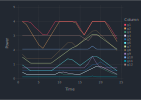

In [28]:
plot1=plot(GenPower, x = Row.index, y=Col.value(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),
    color=Col.index(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),  
    Geom.line,

    Guide.XLabel("Time"),
Guide.YLabel("Power"),
#Guide.Title("Title")
)

In [30]:
PowerBalance = DataFrame();
PowerBalance[:Load] = sum(Pload)*d[:];
PowerBalance[:Gen] = sum(getvalue(p[g,:]) for g=1:NG)*Sbase;
PowerBalance[:SOC] = sum(getvalue(SOC[i,:]) for i=1:NI)*Sbase;
PowerBalance[:Wind] = sum(getvalue(pw[i,:]) for i=1:NI)*Sbase;
PowerBalance

24×4 DataFrames.DataFrame
│ Row │ Load    │ Gen     │ SOC     │ Wind  │
├─────┼─────────┼─────────┼─────────┼───────┤
│ 1   │ 1950.86 │ 1953.95 │ 60.0    │ 35.4  │
│ 2   │ 1835.75 │ 1833.18 │ 60.0    │ 39.0  │
│ 3   │ 1747.25 │ 1734.73 │ 68.2431 │ 52.8  │
│ 4   │ 1709.24 │ 1655.86 │ 102.591 │ 116.4 │
│ 5   │ 1678.29 │ 1583.41 │ 144.384 │ 162.6 │
│ 6   │ 1704.35 │ 1530.91 │ 201.384 │ 255.0 │
│ 7   │ 1786.34 │ 1577.52 │ 258.384 │ 292.8 │
│ 8   │ 1857.47 │ 1671.52 │ 297.04  │ 255.0 │
│ 9   │ 2012.21 │ 1833.36 │ 300.0   │ 217.8 │
│ 10  │ 2242.97 │ 1978.36 │ 233.333 │ 246.6 │
│ 11  │ 2391.2  │ 2036.29 │ 166.667 │ 340.8 │
│ 12  │ 2430.29 │ 2098.99 │ 100.0   │ 319.8 │
│ 13  │ 2481.33 │ 2113.22 │ 72.0    │ 391.8 │
│ 14  │ 2377.62 │ 2062.01 │ 129.0   │ 419.4 │
│ 15  │ 2327.13 │ 1991.43 │ 186.0   │ 435.0 │
│ 16  │ 2335.27 │ 1988.18 │ 243.0   │ 450.0 │
│ 17  │ 2491.1  │ 2218.12 │ 300.0   │ 391.2 │
│ 18  │ 2850.0  │ 2541.82 │ 233.333 │ 299.4 │
│ 19  │ 2803.31 │ 2499.22 │ 166.667 │ 295.2 │
│ 20  │ 2668.65 │ 2407.31 │ 100.0   │ 252.6 │
│ 21  │ 2529.65 │ 2288.31 │ 61.6361 │ 254.4 │
│ 22  │ 2306.5  │ 2094.27 │ 60.0    │ 250.2 │
│ 23  │ 2125.69 │ 1881.27 │ 107.211 │ 325.8 │
│ 24  │ 2090.4  │ 1700.15 │ 60.0    │ 378.0 │

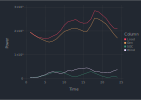

In [31]:
plot2=plot(PowerBalance, x = Row.index, y=Col.value(:Load,:Gen,:SOC,:Wind),
    color=Col.index(:Load,:Gen,:SOC,:Wind),  
    Geom.line,

    
   
  

Guide.XLabel("Time"),
Guide.YLabel("Power"),
#Guide.Title("Title")
)

In [128]:
getvalue(p)

12×24 Array{Float64,2}:
 3.25108   3.00674   2.8478    2.74319   …  3.56055  3.09055   2.91781 
 1.66692   1.49952   1.3612    1.13555      1.47     1.0       1.0     
 1.52      1.52      1.52      1.52         1.52     1.52      1.52    
 1.52      1.52      1.52      1.52         1.52     1.52      1.52    
 0.647442  0.5425    0.5425    0.5425       1.13     0.92      0.71    
 1.55      1.55      1.55      1.55      …  1.55     1.55      1.55    
 1.72273   1.51273   1.33254   1.17442      1.40646  1.19646   1.085   
 1.4       1.4       1.4       1.4          1.68     1.4       1.4     
 2.15196   1.95      1.81573   1.60448      1.99161  1.50161   1.25923 
 2.80844   2.59844   2.38844   2.24097      3.74627  3.53627   3.32627 
 0.12      0.12      0.12      0.12      …  0.12     0.12      0.12    
 0.796003  0.780981  0.773387  0.765155     0.86806  0.644001  0.715667

In [129]:

SOC_Data = DataFrame(x = collect(1:T));
N = []
for n=1:size(NESS_f,1)
    if NESS_f[n] > 0
        append!(N, n)
        Pgen = zeros(T)
        for g=1:NGen
            if Bus[g]==n
                Pgen += getvalue(p[g,:])
                
            end
        end
        SOC_Data[Symbol("Pgen$(n)")] = Pgen        
        #SOC_Data[Symbol("Pij$(n)")] = getvalue(pl[n,:])
        SOC_Data[Symbol("SOC$(n)")] = getvalue(SOC[n,:])
        SOC_Data[Symbol("Pw$(n)")] = getvalue(pw[n,:])
        SOC_Data[Symbol("Pd$(n)")] = getvalue(pd[n,:])
        SOC_Data[Symbol("Pc$(n)")] = getvalue(pc[n,:])
        SOC_Data[Symbol("Load$(n)")] = Pload[n]*d[:]/Sbase
        
        
    end
end



# for i in N
#     n = 
#     SOC_Data[Symbol("Pgen$(n)")] = getvalue(p[n,:])'
#     #SOC_Data[:'SOC$(n)'] = getvalue(SOC[n,:]
# end
SOC_Data            
            
#             @variable(m, p[g=1:NG,t=1:T]);

# @variable(m, pl[l=1:NL,t=1:T]);

# @variable(m, θ[i=1:NI,t=1:T]);
# @variable(m, Ls[i=1:NI,t=1:T]);
# @variable(m, SOC[i=1:NI,t=1:T]);
# @variable(m, pd[i=1:NI,t=1:T]);
# @variable(m, pc[i=1:NI,t=1:T]);
# @variable(m, pw[i=1:NI,t=1:T]);
# @variable(m, pwc[i=1:NI,t=1:T]);
# @variable(m, NESS[i=1:NI], Int);

In [130]:
SOC_Data

24×31 DataFrames.DataFrame. Omitted printing of 25 columns
│ Row │ x  │ Pgen1 │ SOC1     │ Pw1          │ Pd1         │ Pc1         │
├─────┼────┼───────┼──────────┼──────────────┼─────────────┼─────────────┤
│ 1   │ 1  │ 1.52  │ 0.2      │ -2.43625e-19 │ 1.59055e-8  │ 4.60577e-8  │
│ 2   │ 2  │ 1.52  │ 0.206277 │ -9.10597e-18 │ 9.30045e-9  │ 0.00660783  │
│ 3   │ 3  │ 1.52  │ 0.302746 │ 8.1524e-18   │ 9.30055e-9  │ 0.101546    │
│ 4   │ 4  │ 1.52  │ 0.433187 │ 9.10177e-18  │ 9.30055e-9  │ 0.137307    │
│ 5   │ 5  │ 1.52  │ 0.595776 │ 1.04193e-17  │ 9.30057e-9  │ 0.171146    │
│ 6   │ 6  │ 1.52  │ 0.785776 │ 2.85017e-18  │ 6.47036e-9  │ 0.2         │
│ 7   │ 7  │ 1.52  │ 0.935888 │ 9.59585e-18  │ 9.30056e-9  │ 0.158013    │
│ 8   │ 8  │ 1.52  │ 1.0      │ 7.35814e-18  │ 9.30054e-9  │ 0.0674858   │
│ 9   │ 9  │ 1.52  │ 1.0      │ -6.05286e-18 │ 1.58875e-8  │ 4.99803e-8  │
│ 10  │ 10 │ 1.52  │ 1.0      │ 2.60856e-18  │ 2.31231e-7  │ 6.39567e-9  │
│ 11  │ 11 │ 1.52  │ 0.920647 │ -3.11122e-17 │ 0.0714177   │ 5.21143e-9  │
│ 12  │ 12 │ 1.52  │ 0.820816 │ -3.20856e-17 │ 0.0898476   │ 5.21144e-9  │
│ 13  │ 13 │ 1.52  │ 0.696189 │ -3.2608e-17  │ 0.112164    │ 5.21144e-9  │
│ 14  │ 14 │ 1.52  │ 0.696058 │ 9.31142e-17  │ 0.000117869 │ 5.21261e-9  │
│ 15  │ 15 │ 1.52  │ 0.696058 │ -3.44512e-18 │ 1.76252e-8  │ 2.38511e-8  │
│ 16  │ 16 │ 1.52  │ 0.81     │ -2.77261e-17 │ 5.21144e-9  │ 0.119939    │
│ 17  │ 17 │ 1.38  │ 1.0      │ -1.26243e-18 │ -7.58615e-9 │ 0.2         │
│ 18  │ 18 │ 1.52  │ 0.777778 │ 1.50183e-17  │ 0.2         │ -8.83668e-9 │
│ 19  │ 19 │ 1.52  │ 0.555556 │ -1.2839e-18  │ 0.2         │ -2.74517e-9 │
│ 20  │ 20 │ 1.52  │ 0.333333 │ -3.02802e-18 │ 0.2         │ 1.49967e-9  │
│ 21  │ 21 │ 1.52  │ 0.2      │ -1.78499e-18 │ 0.12        │ 4.12303e-9  │
│ 22  │ 22 │ 1.52  │ 0.2      │ 3.39646e-18  │ 7.31933e-8  │ 7.57755e-9  │
│ 23  │ 23 │ 1.52  │ 0.2      │ -7.19509e-19 │ 1.58322e-8  │ 5.51446e-8  │
│ 24  │ 24 │ 1.52  │ 0.2      │ 2.31626e-18  │ 5.27414e-8  │ 1.89008e-8  │

In [131]:
n=1
SOC_Data_sort = stack(SOC_Data, (n+1):(6*n+1))

144×27 DataFrames.DataFrame. Omitted printing of 21 columns
│ Row │ variable │ value    │ x  │ Pgen2 │ SOC2     │ Pw2          │
├─────┼──────────┼──────────┼────┼───────┼──────────┼──────────────┤
│ 1   │ Pgen1    │ 1.52     │ 1  │ 1.52  │ 0.2      │ -2.48375e-19 │
│ 2   │ Pgen1    │ 1.52     │ 2  │ 1.52  │ 0.225461 │ 2.16184e-18  │
│ 3   │ Pgen1    │ 1.52     │ 3  │ 1.52  │ 0.329137 │ 6.22743e-18  │
│ 4   │ Pgen1    │ 1.52     │ 4  │ 1.52  │ 0.452175 │ 6.84515e-18  │
│ 5   │ Pgen1    │ 1.52     │ 5  │ 1.52  │ 0.595813 │ 7.39756e-18  │
│ 6   │ Pgen1    │ 1.52     │ 6  │ 1.52  │ 0.785813 │ 2.87075e-18  │
│ 7   │ Pgen1    │ 1.52     │ 7  │ 1.52  │ 0.92489  │ 7.11579e-18  │
│ 8   │ Pgen1    │ 1.52     │ 8  │ 1.52  │ 1.0      │ 5.50583e-18  │
│ 9   │ Pgen1    │ 1.52     │ 9  │ 1.52  │ 1.0      │ -6.05656e-18 │
│ 10  │ Pgen1    │ 1.52     │ 10 │ 1.52  │ 1.0      │ 2.70816e-18  │
│ 11  │ Pgen1    │ 1.52     │ 11 │ 1.52  │ 0.923656 │ -6.32517e-18 │
⋮
│ 133 │ Load1    │ 0.940293 │ 13 │ 1.52  │ 0.7221   │ -7.76826e-18 │
│ 134 │ Load1    │ 0.900994 │ 14 │ 1.52  │ 0.714562 │ 7.3407e-19   │
│ 135 │ Load1    │ 0.881859 │ 15 │ 1.52  │ 0.714562 │ -3.4611e-18  │
│ 136 │ Load1    │ 0.884946 │ 16 │ 1.52  │ 0.81     │ -6.90921e-18 │
│ 137 │ Load1    │ 0.943997 │ 17 │ 1.38  │ 1.0      │ -1.2604e-18  │
│ 138 │ Load1    │ 1.08     │ 18 │ 1.52  │ 0.777778 │ 1.50146e-17  │
│ 139 │ Load1    │ 1.06231  │ 19 │ 1.52  │ 0.555556 │ -1.29574e-18 │
│ 140 │ Load1    │ 1.01128  │ 20 │ 1.52  │ 0.333333 │ -3.05676e-18 │
│ 141 │ Load1    │ 0.958605 │ 21 │ 1.52  │ 0.2      │ -1.80049e-18 │
│ 142 │ Load1    │ 0.874041 │ 22 │ 1.52  │ 0.2      │ 3.42282e-18  │
│ 143 │ Load1    │ 0.805525 │ 23 │ 1.52  │ 0.2      │ -7.38364e-19 │
│ 144 │ Load1    │ 0.792151 │ 24 │ 1.52  │ 0.2      │ 2.33031e-18  │

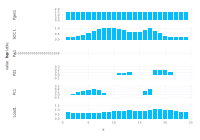

In [132]:
n=1
n=N[n]
set_default_plot_size(20cm, 14cm)
#plot(SOC_Data_sort, ygroup=(Symbol("Зпут$(n)"),Symbol("SOC$(n)"),Symbol("Pw$(n)"),Symbol("Pd$(n)"),Symbol("Pc$(n)"), x="x", y="value", Geom.subplot_grid(Geom.point))
plot(SOC_Data_sort, ygroup="variable", x="x", y="value", Geom.subplot_grid(Geom.bar,free_y_axis=true),
Theme(bar_spacing=1mm))

In [191]:

Line_Data = DataFrame(x = collect(1:T));
N_L = []
for n=1:size(NESS_f,1)
    if NESS_f[n] > 0
        
       
        for l=1:NLines 
            if (Nodes[l,1]==n) | (Nodes[l,2]==n)
                if !(l in N_L)
                    append!(N_L, l)
                    Line_Data[Symbol("P$(Nodes[l,1]),$(Nodes[l,2])")] = getvalue(pl[l,:])
               end
            end
        end
    end
end

Line_Data

24×11 DataFrames.DataFrame. Omitted printing of 5 columns
│ Row │ x  │ P1,2         │ P1,3       │ P1,5     │ P2,4     │ P2,6     │
├─────┼────┼──────────────┼────────────┼──────────┼──────────┼──────────┤
│ 1   │ 1  │ -0.0110627   │ 0.230122   │ 0.561669 │ 0.406872 │ 0.43809  │
│ 2   │ 2  │ -0.00691957  │ 0.252502   │ 0.572157 │ 0.419574 │ 0.441906 │
│ 3   │ 3  │ -0.00691211  │ 0.226559   │ 0.536693 │ 0.39011  │ 0.419168 │
│ 4   │ 4  │ -0.00691192  │ 0.211058   │ 0.530835 │ 0.382667 │ 0.419167 │
│ 5   │ 5  │ -0.00691149  │ 0.196933   │ 0.522849 │ 0.372044 │ 0.418639 │
│ 6   │ 6  │ 0.00071291   │ 0.184839   │ 0.488588 │ 0.345152 │ 0.395483 │
│ 7   │ 7  │ -0.00691179  │ 0.192764   │ 0.499206 │ 0.353308 │ 0.405401 │
│ 8   │ 8  │ -0.00691215  │ 0.224709   │ 0.530835 │ 0.382667 │ 0.419167 │
│ 9   │ 9  │ -0.0146365   │ 0.228873   │ 0.543241 │ 0.39316  │ 0.427345 │
│ 10  │ 10 │ -0.000192306 │ 0.166213   │ 0.504012 │ 0.350427 │ 0.405984 │
│ 11  │ 11 │ -0.00598891  │ 0.179788   │ 0.51148  │ 0.358815 │ 0.410058 │
│ 12  │ 12 │ -0.00598892  │ 0.183403   │ 0.51148  │ 0.358816 │ 0.410059 │
│ 13  │ 13 │ -0.00598894  │ 0.186379   │ 0.51148  │ 0.358816 │ 0.410058 │
│ 14  │ 14 │ -0.00561039  │ 0.152919   │ 0.471815 │ 0.324034 │ 0.387913 │
│ 15  │ 15 │ -0.0102817   │ 0.175283   │ 0.473139 │ 0.329976 │ 0.387702 │
│ 16  │ 16 │ -0.00512031  │ 0.113295   │ 0.406941 │ 0.269007 │ 0.3506   │
│ 17  │ 17 │ 0.0464203    │ -0.0659293 │ 0.255512 │ 0.123697 │ 0.254874 │
│ 18  │ 18 │ 0.000353583  │ 0.134895   │ 0.504751 │ 0.342136 │ 0.408218 │
│ 19  │ 19 │ -0.00839051  │ 0.159675   │ 0.50641  │ 0.348938 │ 0.408564 │
│ 20  │ 20 │ -0.0133286   │ 0.188984   │ 0.533066 │ 0.374981 │ 0.423413 │
│ 21  │ 21 │ -0.00780295  │ 0.174889   │ 0.514309 │ 0.358833 │ 0.412394 │
│ 22  │ 22 │ 0.000798186  │ 0.15517    │ 0.489991 │ 0.337716 │ 0.398064 │
│ 23  │ 23 │ -0.0187021   │ 0.221276   │ 0.511902 │ 0.368607 │ 0.40921  │
│ 24  │ 24 │ -0.0203021   │ 0.229593   │ 0.518558 │ 0.375335 │ 0.412894 │

In [174]:
Line_Data_sort = stack(Line_Data, 2:size(Line_Data,2))

192×3 DataFrames.DataFrame
│ Row │ variable │ value        │ x  │
├─────┼──────────┼──────────────┼────┤
│ 1   │ P1,2     │ -0.0110627   │ 1  │
│ 2   │ P1,2     │ -0.00691957  │ 2  │
│ 3   │ P1,2     │ -0.00691211  │ 3  │
│ 4   │ P1,2     │ -0.00691192  │ 4  │
│ 5   │ P1,2     │ -0.00691149  │ 5  │
│ 6   │ P1,2     │ 0.00071291   │ 6  │
│ 7   │ P1,2     │ -0.00691179  │ 7  │
│ 8   │ P1,2     │ -0.00691215  │ 8  │
│ 9   │ P1,2     │ -0.0146365   │ 9  │
│ 10  │ P1,2     │ -0.000192306 │ 10 │
│ 11  │ P1,2     │ -0.00598891  │ 11 │
⋮
│ 181 │ P6,10    │ -0.706713    │ 13 │
│ 182 │ P6,10    │ -0.746672    │ 14 │
│ 183 │ P6,10    │ -0.722787    │ 15 │
│ 184 │ P6,10    │ -0.856643    │ 16 │
│ 185 │ P6,10    │ -1.05386     │ 17 │
│ 186 │ P6,10    │ -0.831782    │ 18 │
│ 187 │ P6,10    │ -0.809154    │ 19 │
│ 188 │ P6,10    │ -0.730049    │ 20 │
│ 189 │ P6,10    │ -0.722739    │ 21 │
│ 190 │ P6,10    │ -0.70258     │ 22 │
│ 191 │ P6,10    │ -0.605154    │ 23 │
│ 192 │ P6,10    │ -0.58463     │ 24 │

In [175]:
sp = unique(Line_Data_sort[:variable])
Dhl = DataFrame(x = 1:size(N_L,1),yint = N_L, variable = sp)
for l=1:NL
    if l in Dhl[:yint]
        Dhl[:lim] = SLmax[l]/Sbase
    end
end
Dhl

8×4 DataFrames.DataFrame
│ Row │ x │ yint │ variable │ lim  │
├─────┼───┼──────┼──────────┼──────┤
│ 1   │ 1 │ 1    │ P1,2     │ 1.75 │
│ 2   │ 2 │ 2    │ P1,3     │ 1.75 │
│ 3   │ 3 │ 3    │ P1,5     │ 1.75 │
│ 4   │ 4 │ 4    │ P2,4     │ 1.75 │
│ 5   │ 5 │ 5    │ P2,6     │ 1.75 │
│ 6   │ 6 │ 8    │ P4,9     │ 1.75 │
│ 7   │ 7 │ 9    │ P5,10    │ 1.75 │
│ 8   │ 8 │ 10   │ P6,10    │ 1.75 │

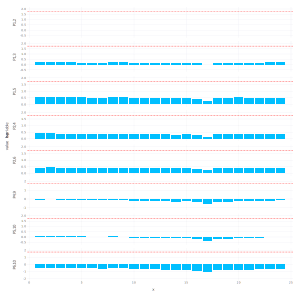

In [176]:
set_default_plot_size(30cm, 30cm)
#plot(SOC_Data_sort, ygroup=(Symbol("Зпут$(n)"),Symbol("SOC$(n)"),Symbol("Pw$(n)"),Symbol("Pd$(n)"),Symbol("Pc$(n)"), x="x", y="value", Geom.subplot_grid(Geom.point))
plot(Line_Data_sort, ygroup="variable", x="x", y="value", 
    Geom.subplot_grid(
        layer(Geom.bar),
        layer(Dhl, ygroup=:variable, yintercept=:lim, Geom.hline(color="red", style=:dot)),
        free_y_axis=true),
# xintercept=[42, 138],
# Geom.vline(color =["red"],style=[:dash]),
Theme(bar_spacing=1mm))

In [195]:
N_L_full = []
Line_Data_full = DataFrame(x = collect(1:T));
for n=1:NBuses
    for l=1:NLines 
        if (Nodes[l,1]==n) | (Nodes[l,2]==n)
            if !(l in N_L_full)
                append!(N_L_full, l)
                Line_Data_full[Symbol("P$(Nodes[l,1]),$(Nodes[l,2])")] = getvalue(pl[l,:])
            end
        end
    end
    
end

Line_Data_sort_full = stack(Line_Data_full, 2:size(Line_Data_full,2))

816×3 DataFrames.DataFrame
│ Row │ variable │ value        │ x  │
├─────┼──────────┼──────────────┼────┤
│ 1   │ P1,2     │ -0.0110627   │ 1  │
│ 2   │ P1,2     │ -0.00691957  │ 2  │
│ 3   │ P1,2     │ -0.00691211  │ 3  │
│ 4   │ P1,2     │ -0.00691192  │ 4  │
│ 5   │ P1,2     │ -0.00691149  │ 5  │
│ 6   │ P1,2     │ 0.00071291   │ 6  │
│ 7   │ P1,2     │ -0.00691179  │ 7  │
│ 8   │ P1,2     │ -0.00691215  │ 8  │
│ 9   │ P1,2     │ -0.0146365   │ 9  │
│ 10  │ P1,2     │ -0.000192306 │ 10 │
│ 11  │ P1,2     │ -0.00598891  │ 11 │
⋮
│ 805 │ P21,22   │ -0.398412    │ 13 │
│ 806 │ P21,22   │ -0.382729    │ 14 │
│ 807 │ P21,22   │ -0.369747    │ 15 │
│ 808 │ P21,22   │ -0.214042    │ 16 │
│ 809 │ P21,22   │ -0.403558    │ 17 │
│ 810 │ P21,22   │ -0.592577    │ 18 │
│ 811 │ P21,22   │ -0.403393    │ 19 │
│ 812 │ P21,22   │ -0.403392    │ 20 │
│ 813 │ P21,22   │ -0.403392    │ 21 │
│ 814 │ P21,22   │ -0.433013    │ 22 │
│ 815 │ P21,22   │ -0.319542    │ 23 │
│ 816 │ P21,22   │ -0.359934    │ 24 │

In [196]:
sp1 = unique(Line_Data_sort_full[:variable])
Dhl1 = DataFrame(x = 1:size(N_L,1),yint = N_L, variable = sp1)
for l=1:NL
    if l in Dhl1[:yint]
        Dhl1[:lim] = SLmax[l]/Sbase
    end
end


34×4 DataFrames.DataFrame
│ Row │ x  │ yint │ variable │ lim │
├─────┼────┼──────┼──────────┼─────┤
│ 1   │ 1  │ 1    │ P1,2     │ 5.0 │
│ 2   │ 2  │ 2    │ P1,3     │ 5.0 │
│ 3   │ 3  │ 3    │ P1,5     │ 5.0 │
│ 4   │ 4  │ 4    │ P2,4     │ 5.0 │
│ 5   │ 5  │ 5    │ P2,6     │ 5.0 │
│ 6   │ 6  │ 8    │ P3,9     │ 5.0 │
│ 7   │ 7  │ 9    │ P3,24    │ 5.0 │
│ 8   │ 8  │ 10   │ P4,9     │ 5.0 │
│ 9   │ 9  │ 6    │ P5,10    │ 5.0 │
│ 10  │ 10 │ 7    │ P6,10    │ 5.0 │
│ 11  │ 11 │ 11   │ P7,8     │ 5.0 │
⋮
│ 23  │ 23 │ 23   │ P14,16   │ 5.0 │
│ 24  │ 24 │ 24   │ P15,16   │ 5.0 │
│ 25  │ 25 │ 25   │ P15,21   │ 5.0 │
│ 26  │ 26 │ 26   │ P15,24   │ 5.0 │
│ 27  │ 27 │ 27   │ P16,17   │ 5.0 │
│ 28  │ 28 │ 28   │ P16,19   │ 5.0 │
│ 29  │ 29 │ 29   │ P17,18   │ 5.0 │
│ 30  │ 30 │ 30   │ P17,22   │ 5.0 │
│ 31  │ 31 │ 31   │ P18,21   │ 5.0 │
│ 32  │ 32 │ 32   │ P19,20   │ 5.0 │
│ 33  │ 33 │ 33   │ P20,23   │ 5.0 │
│ 34  │ 34 │ 34   │ P21,22   │ 5.0 │

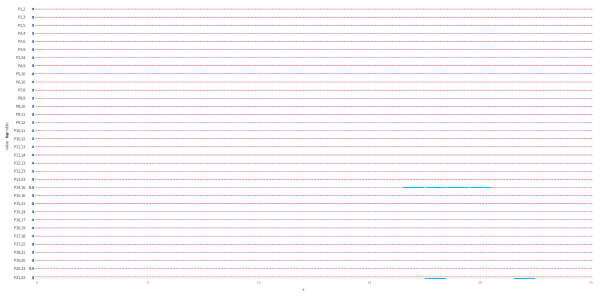

In [198]:
set_default_plot_size(0cm, 30cm)
#plot(SOC_Data_sort, ygroup=(Symbol("Зпут$(n)"),Symbol("SOC$(n)"),Symbol("Pw$(n)"),Symbol("Pd$(n)"),Symbol("Pc$(n)"), x="x", y="value", Geom.subplot_grid(Geom.point))
plot(Line_Data_sort_full, ygroup="variable", x="x", y="value", 
    Geom.subplot_grid(
        layer(Geom.bar),
        layer(Dhl1, ygroup=:variable, yintercept=:lim, Geom.hline(color="red", style=:dot)),
        free_y_axis=true),
# xintercept=[42, 138],
# Geom.vline(color =["red"],style=[:dash]),
Theme(bar_spacing=1mm))

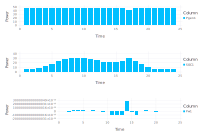

In [74]:
n = 1
n = N[n]
p1=plot(SOC_Data, x = Row.index, y=Col.value(Symbol("Pgen$(n)")),  
    color=Col.index(Symbol("Pgen$(n)")),
    Geom.bar,
   
    Guide.YLabel("Power"),
    Theme(bar_spacing=1mm),
    #Guide.Title("Title"),
    Guide.XLabel("Time"),
    )
p2=plot(SOC_Data, x = Row.index, y=Col.value(Symbol("SOC$(n)")),  
    color=Col.index(Symbol("SOC$(n)")),
    Geom.bar,
   
    Guide.YLabel("Power"),
    Theme(bar_spacing=1mm),
    #Guide.Title("Title"),
    Guide.XLabel("Time"),
    )

p3=plot(SOC_Data, x = Row.index, y=Col.value(Symbol("Pw$(n)")),  
    color=Col.index(Symbol("Pw$(n)")),
    Geom.bar,
   
    Guide.YLabel("Power"),
    Theme(bar_spacing=1mm),
    #Guide.Title("Title"),
    Guide.XLabel("Time"),
    )

vstack(p1,p2,p3)
 
#,Symbol("SOC$(n)"),Symbol("Pw$(n)"),Symbol("Pd$(n)"),Symbol("Pc$(n)")

In [106]:
getvalue(Ls)

24×24 Array{Float64,2}:
 -9.99088e-9   -9.99088e-9   -9.99088e-9   …  -9.99088e-9   -9.99088e-9 
 -9.99088e-9   -9.99088e-9   -9.99088e-9      -9.99088e-9   -9.99088e-9 
 -9.99087e-9   -9.99087e-9   -9.99088e-9      -9.99087e-9   -9.99087e-9 
 -9.99087e-9   -9.99087e-9   -9.99087e-9      -9.99087e-9   -9.99087e-9 
 -9.99087e-9   -9.99087e-9   -9.99088e-9      -9.99087e-9   -9.99087e-9 
 -9.99086e-9   -9.99087e-9   -9.99087e-9   …  -9.99087e-9   -9.99087e-9 
 -9.99089e-9   -9.99089e-9   -9.99089e-9      -9.99089e-9   -9.99089e-9 
 -9.99088e-9   -9.99088e-9   -9.99088e-9      -9.99089e-9   -9.99089e-9 
 -9.99087e-9   -9.99088e-9   -9.99088e-9      -9.99088e-9   -9.99088e-9 
 -9.99087e-9   -9.99087e-9   -9.99087e-9      -9.99087e-9   -9.99087e-9 
  1.88705e-18  -4.94043e-18  -8.42416e-19  …   7.79539e-19   2.25251e-18
  2.75238e-18  -6.03205e-18  -6.67944e-19      7.70805e-19   2.48623e-18
 -9.99089e-9   -9.99089e-9   -9.99089e-9      -9.9909e-9    -9.99089e-9 
 -9.99088e-9   -9.99089e-9 

In [121]:
using DataFrames
set_default_plot_size(8cm, 12cm)

widedf = DataFrame(x = collect(1:10), var1 = collect(1:10), var2 = collect(1:10).^2)


20×3 DataFrames.DataFrame
│ Row │ variable │ value │ x  │
├─────┼──────────┼───────┼────┤
│ 1   │ var1     │ 1     │ 1  │
│ 2   │ var1     │ 2     │ 2  │
│ 3   │ var1     │ 3     │ 3  │
│ 4   │ var1     │ 4     │ 4  │
│ 5   │ var1     │ 5     │ 5  │
│ 6   │ var1     │ 6     │ 6  │
│ 7   │ var1     │ 7     │ 7  │
│ 8   │ var1     │ 8     │ 8  │
│ 9   │ var1     │ 9     │ 9  │
│ 10  │ var1     │ 10    │ 10 │
│ 11  │ var2     │ 1     │ 1  │
│ 12  │ var2     │ 4     │ 2  │
│ 13  │ var2     │ 9     │ 3  │
│ 14  │ var2     │ 16    │ 4  │
│ 15  │ var2     │ 25    │ 5  │
│ 16  │ var2     │ 36    │ 6  │
│ 17  │ var2     │ 49    │ 7  │
│ 18  │ var2     │ 64    │ 8  │
│ 19  │ var2     │ 81    │ 9  │
│ 20  │ var2     │ 100   │ 10 │

In [123]:
plot(longdf, ygroup="var", x="x", y="value", Geom.subplot_grid(Geom.point))


LoadError: [91mKeyError: key :var1 not found[39m

In [67]:
l=1
n=1
Nodes[l,1]==n | Nodes[l,2]==n

false

In [71]:
Symbol("P$(Nodes[l,1])$(Nodes[l,2])")

:P12

In [2]:
norm([1,2,3])

3.7416573867739413

In [18]:
norm(2*sqrt(r_loss)*(pd[i,t]+pc[i,t]),1-ESS_loss[i,t]) <= 1+ESS_loss[i,t]

LoadError: [91mUndefVarError: i not defined[39m